In [1]:
import matplotlib.pyplot as plt  # 画图模块
import numpy as np # 数据处理最重要的模块
import pandas as pd # 数据处理最重要的模块
import scipy.stats as stats # 统计模块
import scipy
from datetime import datetime # 时间模块
from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
import statsmodels.formula.api as smf  # OLS regression
import pyreadr # read RDS file
from matplotlib import style
import matplotlib.dates as mdates
from pandas._libs.tslibs.offsets import MonthEnd

# from matplotlib.font_manager import FontProperties # 作图中文
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['font.family'] = 'Times New Roman'

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

plt.rcParams['font.sans-serif'] = ['SimHei'] # 或者其他支持中文的字体
plt.rcParams['axes.unicode_minus'] = False # 正确显示负号

# Stock Market Excess Return

In [6]:
# Load Market Returns
# Cmmvosd [综合月市场总流通市值] - 月内所有个股的流通市值 汇总数。计算公式为：流通股数*月收盘价。 计量货币：人民币元，注意单位是千
marketret_mon_stock = pd.read_excel('D:/Academic/academic/Assetpricing/Input/Market_Return/TRD_Cnmont2023.xlsx', sheet_name= 'sheet1')
marketret_mon_stock = marketret_mon_stock[marketret_mon_stock['Markettype'] == 21]
marketret_mon_stock = marketret_mon_stock[['Trdmnt', 'Cmretwdos', 'Cmretwdeq','Cmmvosd']].dropna()
# month 列 + 月末
marketret_mon_stock['month'] = pd.to_datetime(marketret_mon_stock['Trdmnt'],format='%Y-%m') + MonthEnd(0)
marketret_mon_stock['MarketR'] = marketret_mon_stock['Cmretwdos'].astype(float)
marketret_mon_stock['MarketR_e'] = marketret_mon_stock['Cmretwdeq'].astype(float)
marketret_mon_stock['Marketvalue'] = marketret_mon_stock['Cmmvosd'].astype(float)
marketret_mon_stock = marketret_mon_stock[['month', 'MarketR', 'MarketR_e','Marketvalue']]
marketret_mon_stock

E:\anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,month,MarketR,MarketR_e,Marketvalue
21,1991-01-31,0.029998,0.036554,1.931395e+06
39,1991-02-28,0.010203,0.021860,1.819734e+06
57,1991-03-31,-0.099663,-0.060425,1.468212e+06
75,1991-04-30,-0.079652,-0.031449,2.508786e+06
93,1991-05-31,-0.074521,0.005375,2.321827e+06
...,...,...,...,...
7440,2023-08-31,-0.055570,-0.041538,6.590503e+10
7459,2023-09-30,-0.005689,0.000357,6.571682e+10
7478,2023-10-31,-0.026321,-0.009959,6.414343e+10
7497,2023-11-30,0.001790,0.034280,6.445576e+10


In [7]:
# Load Risk Free Rate
riskfree = pd.read_excel('D:/Academic/academic/Assetpricing/Input/Market_Return/TRD_Nrrate2023.xlsx')
riskfree_mon = riskfree[['Clsdt', 'Nrrmtdt']].dropna()
riskfree_mon = riskfree_mon.drop([0,1])
riskfree_mon['month'] = pd.to_datetime(riskfree_mon['Clsdt'],format='%Y-%m-%d')
riskfree_mon['rfmonth'] = riskfree_mon['Nrrmtdt'].astype(float) / 100
riskfree_mon = riskfree_mon.groupby('month').agg({'rfmonth':'mean'}).reset_index()
riskfree_mon

E:\anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,month,rfmonth
0,1990-04-15,0.008035
1,1990-08-21,0.006930
2,1990-12-19,0.006930
3,1990-12-20,0.006930
4,1990-12-21,0.006930
...,...,...
12063,2023-12-27,0.001241
12064,2023-12-28,0.001241
12065,2023-12-29,0.001241
12066,2023-12-30,0.001241


In [8]:
# Calculate Excess Returns
ts = marketret_mon_stock.merge(riskfree_mon, on='month', how='left')
ts['ret'] = ts['MarketR'] - ts['rfmonth']
ts['ret_e'] = ts['MarketR_e'] - ts['rfmonth']
ts.set_index('month', inplace=True)
ts

,MarketR,MarketR_e,Marketvalue,rfmonth,ret,ret_e
month,,,,,,
1991-01-31,0.029998,0.036554,1.931395e+06,0.006930,0.023068,0.029624
1991-02-28,0.010203,0.021860,1.819734e+06,0.006930,0.003273,0.014930
1991-03-31,-0.099663,-0.060425,1.468212e+06,0.006930,-0.106593,-0.067355
1991-04-30,-0.079652,-0.031449,2.508786e+06,0.006092,-0.085744,-0.037541
1991-05-31,-0.074521,0.005375,2.321827e+06,0.006092,-0.080613,-0.000717
...,...,...,...,...,...,...
2023-08-31,-0.055570,-0.041538,6.590503e+10,0.001241,-0.056811,-0.042779
2023-09-30,-0.005689,0.000357,6.571682e+10,0.001241,-0.006930,-0.000884
2023-10-31,-0.026321,-0.009959,6.414343e+10,0.001241,-0.027562,-0.011200


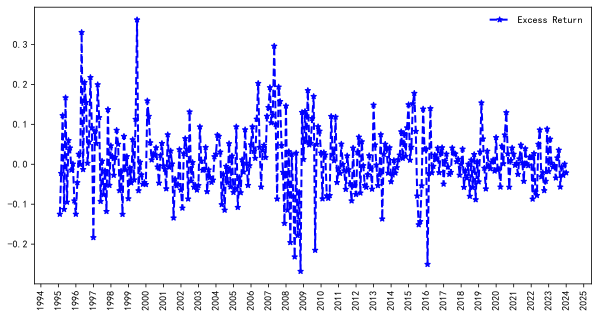

In [16]:
# Plot the Excess Returns

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    'ret',  # 要画图的变量名
    '*--b',  # 线的类型
    label = 'Excess Return',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = ts['1995':'2023'])  # 画图的数据

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)
# 添加图例
plt.legend(loc='upper right', frameon=False, fontsize=10)
plt.show();

# Predictors - Price-Dividend Ratio

In [6]:
# Predictors - Price-Dividend Ratio
dividends = pd.read_excel('D:/Academic/academic/Assetpricing/Input/Dividend/DPR_Acptl202312.xlsx')
dividends = dividends[dividends['Disttyp'] == 'CA']
dividends['month'] = pd.to_datetime(dividends['Exdistdt'],format='%Y-%m-%d')
dividends

E:\anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,Disttyp,Exdistdt,Annodt,Paydt,Amount,Roprc,month
3,000001,CA,1991-05-02,NaN,NaN,0.3,0,1991-05-02
6,000001,CA,1992-03-23,1992-03-14,1992-03-23,0.2,0,1992-03-23
8,000001,CA,1993-05-24,1993-05-09,1993-05-24,0.3,0,1993-05-24
11,000001,CA,1994-07-11,1994-07-02,1994-07-14,0.5,0,1994-07-11
14,000001,CA,1995-09-25,1995-09-15,1995-09-27,0.3,0,1995-09-25
...,...,...,...,...,...,...,...,...
57452,900956,CA,2019-05-13,2019-05-07,2019-05-22,0.1,0,2019-05-13
57453,900956,CA,2019-12-04,2019-11-28,2019-12-17,0.15,0,2019-12-04
57454,900957,CA,2001-05-18,2001-05-12,2001-05-23,0.019947,0,2001-05-18
57455,900957,CA,2002-06-12,2002-06-08,2002-06-26,0.019997,0,2002-06-12


In [7]:
# Perform data cleaning and filtering
dividends = dividends[['Stkcd', 'Disttyp', 'month', 'Amount']].dropna()
dividends = dividends[(dividends['Stkcd'].str.startswith(('0', '3', '6'))) & (dividends['Disttyp'] == 'CA')]

# month 列改成月末
dividends['month'] = dividends['month'] + MonthEnd(0)

# Filter rows where 'month' is less than or equal to December 2023
dividends = dividends[dividends['month'] <= '2023-12-31']

dividends

,Stkcd,Disttyp,month,Amount
3,000001,CA,1991-05-31,0.3
6,000001,CA,1992-03-31,0.2
8,000001,CA,1993-05-31,0.3
11,000001,CA,1994-07-31,0.5
14,000001,CA,1995-09-30,0.3
...,...,...,...,...
55537,688800,CA,2022-05-31,0.32
55538,688800,CA,2023-05-31,0.52
55540,688819,CA,2021-05-31,0.6
55541,688819,CA,2022-06-30,0.6


In [8]:
import pyreadr

# Read the RDS file
ret_day_ST = pyreadr.read_r('D:/Academic/academic/Assetpricing/Output/ret_day_ST2023.RDS')

# The result is a dictionary where keys are the names of objects in the RDS file.
# Usually, an RDS file contains one object, and you can access it with result[None].
ret_day_ST = ret_day_ST[None]

# Check the DataFrame
ret_day_ST

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,TradingVolume,TradingMoney,CirculationValue,TotalValue,Return_1,Return_2,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,All_shares,A_float_shares,H_float_shares,Pre_shares,ratio
0,000001,1991-04-03,49.0,49.0,49.0,49.0,100.0,5000.0,1.298500e+09,2.376508e+09,0.225,0.225,49.0,49.0,4.0,1991-04-03,1.0,NaN,NaN,NaN,NaN,4.8500171E7,2.65E7,0.0,0.0,0.54639
1,000001,1991-04-04,48.76,48.76,48.76,48.76,300.0,15000.0,1.292140e+09,2.364868e+09,-0.004898,-0.004898,48.76,48.76,4.0,1991-04-03,1.0,NaN,NaN,49.0,-0.004898,4.8500171E7,2.65E7,0.0,0.0,0.54639
2,000001,1991-04-05,48.52,48.52,48.52,48.52,200.0,10000.0,1.285780e+09,2.353228e+09,-0.004922,-0.004922,48.52,48.52,4.0,1991-04-03,1.0,NaN,NaN,48.76,-0.004922,4.8500171E7,2.65E7,0.0,0.0,0.54639
3,000001,1991-04-06,48.28,48.28,48.28,48.28,700.0,34000.0,1.279420e+09,2.341588e+09,-0.004946,-0.004946,48.28,48.28,4.0,1991-04-03,1.0,NaN,NaN,48.52,-0.004946,4.8500171E7,2.65E7,0.0,0.0,0.54639
4,000001,1991-04-08,48.04,48.04,48.04,48.04,200.0,10000.0,1.273060e+09,2.329948e+09,-0.004971,-0.004971,48.04,48.04,4.0,1991-04-03,1.0,NaN,NaN,48.28,-0.004971,4.8500171E7,2.65E7,0.0,0.0,0.54639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14162867,605599,2023-12-25,13.72,13.95,13.63,13.68,1123800.0,1.5408619E7,8.025752e+09,1.064000e+10,-0.007977,-0.007977,14.682455,13.679988,1.0,2022-09-09,1.0,0.0,0.0,13.79,-0.007977,7.777778E8,5.866778E8,0.0,0.0,0.75430
14162868,605599,2023-12-26,13.73,14.28,13.68,14.2,3363098.0,4.7457716E7,8.330825e+09,1.104444e+10,0.038012,0.038012,15.24056,14.199988,1.0,2022-09-09,1.0,0.0,0.0,13.68,0.038012,7.777778E8,5.866778E8,0.0,0.0,0.75430
14162869,605599,2023-12-27,14.38,14.38,13.95,14.09,2126902.0,2.9931073E7,8.266290e+09,1.095889e+10,-0.007746,-0.007746,15.122499,14.089988,1.0,2022-09-09,1.0,0.0,0.0,14.2,-0.007746,7.777778E8,5.866778E8,0.0,0.0,0.75430
14162870,605599,2023-12-28,14.06,14.35,14.01,14.23,2708873.0,3.8435385E7,8.348425e+09,1.106778e+10,0.009936,0.009936,15.272758,14.229988,1.0,2022-09-09,1.0,0.0,0.0,14.09,0.009936,7.777778E8,5.866778E8,0.0,0.0,0.75430


In [9]:
# 取每个股票每个月最后一个交易日的数据
ret_day_ST['month'] = pd.to_datetime(ret_day_ST['Day'],format='%Y-%m-%d') + MonthEnd(0)
ret_day_ST = ret_day_ST.groupby(['Stkcd', 'month']).tail(1)
ret_day_ST

,Stkcd,Day,Opnprc,Hiprc,Loprc,Clsprc,TradingVolume,TradingMoney,CirculationValue,TotalValue,Return_1,Return_2,Adjprcwd,Adjprcnd,Markettype,Capchgdt,Trdsta,Ahshrtrd_D,Ahvaltrd_D,PreClosePrice,ChangeRatio,All_shares,A_float_shares,H_float_shares,Pre_shares,ratio,month
19,000001,1991-04-30,43.68,43.68,43.68,43.68,200.0,9000.0,1.157520e+09,2.118487e+09,-0.005011,-0.005011,43.68,43.68,4.0,1991-04-03,1.0,NaN,NaN,43.9,-0.005011,4.8500171E7,2.65E7,0.0,0.0,0.54639,1991-04-30
43,000001,1991-05-31,38.34,38.34,38.34,38.34,100.0,4000.0,1.016010e+09,1.859497e+09,-0.004931,-0.004931,38.34,38.34,4.0,1991-04-03,1.0,NaN,NaN,38.53,-0.004931,4.8500171E7,2.65E7,0.0,0.0,0.54639,1991-05-31
66,000001,1991-06-28,33.99,33.99,33.99,33.99,200.0,7000.0,9.007350e+08,1.648521e+09,-0.004977,-0.004977,33.99,33.99,4.0,1991-04-03,1.0,NaN,NaN,34.16,-0.004977,4.8500171E7,2.65E7,0.0,0.0,0.54639,1991-06-30
82,000001,1991-07-31,29.54,29.54,29.54,29.54,100.0,2954.0,7.828100e+08,1.432695e+09,-0.005052,-0.005052,29.54,29.54,4.0,1991-04-03,1.0,NaN,NaN,29.69,-0.005052,4.8500171E7,2.65E7,0.0,0.0,0.54639,1991-07-31
97,000001,1991-08-31,15.05,15.05,14.85,15.0,120000.0,1798460.0,6.748338e+08,1.346275e+09,-0.003322,-0.003322,17.381702,17.381702,4.0,1991-08-01,1.0,NaN,NaN,15.05,-0.003322,8.9751643E7,4.4988921E7,0.0,0.0,0.50126,1991-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14162791,605599,2023-08-31,14.05,14.06,13.55,13.56,3585700.0,4.9215603E7,7.955351e+09,1.054667e+10,-0.0335,-0.0335,14.55366,13.559988,1.0,2022-09-09,1.0,0.0,0.0,14.03,-0.0335,7.777778E8,5.866778E8,0.0,0.0,0.75430,2023-08-31
14162811,605599,2023-09-28,14.35,14.56,14.28,14.54,2183902.0,3.1601433E7,8.530295e+09,1.130889e+10,0.007623,0.007623,15.605473,14.539987,1.0,2022-09-09,1.0,0.0,0.0,14.43,0.007623,7.777778E8,5.866778E8,0.0,0.0,0.75430,2023-09-30
14162828,605599,2023-10-31,13.95,13.95,13.67,13.85,1686700.0,2.3357813E7,8.125488e+09,1.077222e+10,-0.010007,-0.010007,14.864912,13.849987,1.0,2022-09-09,1.0,0.0,0.0,13.99,-0.010007,7.777778E8,5.866778E8,0.0,0.0,0.75430,2023-10-31
14162850,605599,2023-11-30,13.6,13.6,13.35,13.48,1117233.0,1.4990684E7,7.908417e+09,1.048444e+10,-0.005166,-0.005166,14.467799,13.479988,1.0,2022-09-09,1.0,0.0,0.0,13.55,-0.005166,7.777778E8,5.866778E8,0.0,0.0,0.75430,2023-11-30


In [10]:
# Merge 'Dividend' with filtered 'ret_day_ST' 
merge_condition = ret_day_ST[['Stkcd', 'month', 'CirculationValue', 'A_float_shares', 'Clsprc']]
Dividend = pd.merge(dividends, merge_condition, on=['Stkcd', 'month'], how='right')
Dividend.sort_values(by=['Stkcd', 'month'], inplace=True)
Dividend

,Stkcd,Disttyp,month,Amount,CirculationValue,A_float_shares,Clsprc
0,000001,NaN,1991-04-30,NaN,1.157520e+09,2.65E7,43.68
1,000001,CA,1991-05-31,0.3,1.016010e+09,2.65E7,38.34
2,000001,NaN,1991-06-30,NaN,9.007350e+08,2.65E7,33.99
3,000001,NaN,1991-07-31,NaN,7.828100e+08,2.65E7,29.54
4,000001,NaN,1991-08-31,NaN,6.748338e+08,4.4988921E7,15.0
...,...,...,...,...,...,...,...
714645,605599,NaN,2023-08-31,NaN,7.955351e+09,5.866778E8,13.56
714646,605599,NaN,2023-09-30,NaN,8.530295e+09,5.866778E8,14.54
714647,605599,NaN,2023-10-31,NaN,8.125488e+09,5.866778E8,13.85
714648,605599,NaN,2023-11-30,NaN,7.908417e+09,5.866778E8,13.48


In [11]:
# Compute market values and dividends
Dividend['d'] = Dividend['Amount'].astype(float) * Dividend['A_float_shares'].astype(float)

# Calculate the sum of dividends for each month 不考虑缺失值
# 去掉Amount列中的缺失值 
Dividend_market = Dividend.dropna(subset=['Amount']).groupby('month').agg({'d':'sum'}).reset_index()
Value_market = Dividend.dropna(subset=['CirculationValue']).groupby('month').agg({'CirculationValue':'sum'}).reset_index()

# Merge the two DataFrames
Dividend_market = pd.merge(Dividend_market, Value_market, on='month', how='right')
Dividend_market


,month,d,CirculationValue
0,1990-12-31,NaN,6.241660e+08
1,1991-01-31,NaN,1.931395e+09
2,1991-02-28,NaN,1.830458e+09
3,1991-03-31,NaN,1.468212e+09
4,1991-04-30,NaN,2.508786e+09
...,...,...,...
392,2023-08-31,7.826270e+10,6.590504e+13
393,2023-09-30,6.013142e+10,6.571665e+13
394,2023-10-31,2.278053e+10,6.414495e+13
395,2023-11-30,1.138245e+10,6.445576e+13


In [12]:
# Calculate lags of dividends for 11 months
for i in range(1, 12):
    Dividend_market[f'd{i}'] = Dividend_market['d'].shift(i)

# Calculate the sum of dividends including the current and previous 11 months
Dividend_market['sum_d'] = Dividend_market[['d'] + [f'd{i}' for i in range(1, 12)]].sum(axis=1)
Dividend_market

,month,d,CirculationValue,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,sum_d
0,1990-12-31,NaN,6.241660e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
1,1991-01-31,NaN,1.931395e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
2,1991-02-28,NaN,1.830458e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
3,1991-03-31,NaN,1.468212e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
4,1991-04-30,NaN,2.508786e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2023-08-31,7.826270e+10,6.590504e+13,6.236896e+11,5.287531e+11,1.633968e+11,3.396404e+10,1.813489e+09,5.592139e+09,2.135191e+09,5.846793e+10,5.343448e+09,1.877097e+10,6.410018e+10,1.584290e+12
393,2023-09-30,6.013142e+10,6.571665e+13,7.826270e+10,6.236896e+11,5.287531e+11,1.633968e+11,3.396404e+10,1.813489e+09,5.592139e+09,2.135191e+09,5.846793e+10,5.343448e+09,1.877097e+10,1.580321e+12
394,2023-10-31,2.278053e+10,6.414495e+13,6.013142e+10,7.826270e+10,6.236896e+11,5.287531e+11,1.633968e+11,3.396404e+10,1.813489e+09,5.592139e+09,2.135191e+09,5.846793e+10,5.343448e+09,1.584330e+12
395,2023-11-30,1.138245e+10,6.445576e+13,2.278053e+10,6.013142e+10,7.826270e+10,6.236896e+11,5.287531e+11,1.633968e+11,3.396404e+10,1.813489e+09,5.592139e+09,2.135191e+09,5.846793e+10,1.590369e+12


In [13]:
# Calculate the Price-Dividend ratio
Dividend_market['pd'] = np.log(Dividend_market['CirculationValue'] / Dividend_market['sum_d'])

# Prepare the final output as needed
Price_dividend_mon = Dividend_market[['month', 'pd']]

Price_dividend_mon.set_index('month', inplace=True)
Price_dividend_mon = Price_dividend_mon['1995-01-01':'2023-12-31']
Price_dividend_mon

,pd
month,
1995-01-31,4.084782
1995-02-28,4.081370
1995-03-31,4.238190
1995-04-30,4.117053
1995-05-31,4.185583
...,...
2023-08-31,3.728079
2023-09-30,3.727724
2023-10-31,3.700984


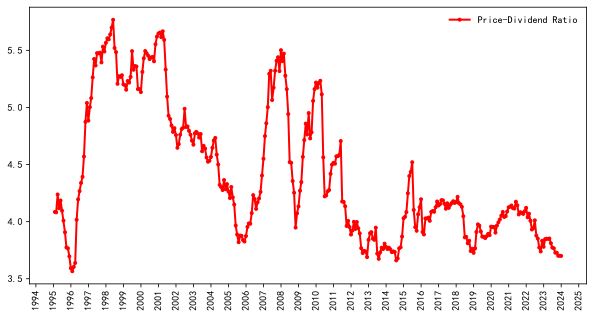

In [14]:
# Plot the Price-Dividend Ratio
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    'pd',  # 要画图的变量名
    '.-r',  # 线的类型
    label = 'Price-Dividend Ratio',  # 这个是线的类别，主要是在多条线画图的时候，起到区别的作用，单条线这个没有影响
    linewidth = 2,  # 线的粗细
    data = Price_dividend_mon)  # 画图的数据

# 设置x轴的日期格式
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
# 设置x轴的刻度间隔
ax.xaxis.set_major_locator(mdates.YearLocator())
# 旋转x轴标签以防止重叠
plt.xticks(rotation=90)
# 添加图例
plt.legend(loc='upper right', frameon=False, fontsize=10)
plt.show();